Adem BAKIRCI<br>

Mastering Applied Data Science with Deep Learning, January 2024 cohort<br>

<h1 align="center">NLP Project Final Project</h1>

# Introduction #
**Problem Statement**: Classifying Amazon reviews based on customer ratings using NLP

<h4 align="center">Impact</h4>

Reviews provide objective feedback to a product and are therefore inherently useful for consumers. These ratings are often summarized by a numerical rating, or the number of stars. Of course there is more value in the actual text itself than the quantified stars. And at times, the given rating does not truly convey the experience of the product – the heart of the feedback is actually in the text itself. The goal therefore is to build a classifier that would understand the essence of a piece of review and assign it the most appropriate rating based on the meaning of the text.

<h4 align="center">Background</h4>

Though product ratings on Amazon are aggregated from all the reviews by every customer, each individual rating is actually only an integer that ranges from one star to five stars. This reduces our predictions to discrete classes totaling five possibilities. Therefore what we'll have is a supervised, multi-class classifier with the actual review text as the core predictor.

This study is an exploration of Natural Language Processing (NLP). The goal of predicting the star rating given a piece of text will take on different NLP topics including word embedding, topic modeling, and dimension reduction. From there, we'll arrive at a final dataframe and we'll be employing different machine learning techniques in order to come up with the best approach (i.e. most accurate estimator) for our classifier.

<h4 align="center" id="Datasets">Datasets</h4>

The [Amazon dataset](http://jmcauley.ucsd.edu/data/amazon/index.html) contains the customer reviews for all listed *Electronics* products spanning from May 1996 up to July 2014. There are a total of 1,689,188 reviews by a total of 192,403 customers on 63,001 unique products. The data dictionary is as follows:

*  **asin** - Unique ID of the product being reviewed, *string*
*  **helpful** - A list with two elements: the number of users that voted *helpful*, and the total number of users that voted on the review (including the *not helpful* votes), *list*
*  **overall** - The reviewer's rating of the product, *int64*
*  **reviewText** - The review text itself, *string*
*  **reviewerID** - Unique ID of the reviewer, *string*
*  **reviewerName** - Specified name of the reviewer, *string*
*  **summary** - Headline summary of the review, *string*
*  **unixReviewTime** - Unix Time of when the review was posted, *string*

## Import Libraries

In [105]:
#pip install wordcloud
#!pip install langdetect
#!pip install textblob
#!pip install xgboost

In [66]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image

from langdetect import detect

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.stem import PorterStemmer
pr = PorterStemmer()

nltk.download('stopwords')
from nltk.corpus import stopwords

from textblob import TextBlob, Word

import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admcn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [120]:
df = pd.read_csv("amazon.csv")
df_copy = df.copy()

In [3]:
# selected only 400000 rows due to memory constraints
df = df.sample(400000)

## EDA

In [4]:
df.sample(3)


,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
1650748,1650748,A2KUCJLJBLEHBH,B00EZAYD4A,Hatem Ashouri,"[1, 1]",I have owned the P7700 for many months and it ...,5,upgrade from P7700,1395619200,"03 24, 2014"
595748,595748,A231JEHXSO2HLL,B002G1YPHA,"Andrew F. ""Andrew""","[2, 2]",I've had this power supply for five months now...,4,"Great, one minor problem",1343865600,"08 2, 2012"
963077,963077,A1H0K1MQTE2V2W,B004I5ERUW,Mackmario8,"[0, 0]",this charger works great. when it arrived it d...,5,perfect just didnt have the head i needed,1402704000,"06 14, 2014"


In [5]:
df.shape

(400000, 10)

In [6]:
df.isnull().sum()

Unnamed: 0           0
reviewerID           0
asin                 0
reviewerName      5950
helpful              0
reviewText         234
overall              0
summary              3
unixReviewTime       0
reviewTime           0
dtype: int64

Only the `overall` and the `unixReviewTime` series are stored as integers. The rest are interpreted as strings (objects).

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 400000 entries, 603537 to 1468876
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      400000 non-null  int64 
 1   reviewerID      400000 non-null  object
 2   asin            400000 non-null  object
 3   reviewerName    394050 non-null  object
 4   helpful         400000 non-null  object
 5   reviewText      399766 non-null  object
 6   overall         400000 non-null  int64 
 7   summary         399997 non-null  object
 8   unixReviewTime  400000 non-null  int64 
 9   reviewTime      400000 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.6+ MB
None


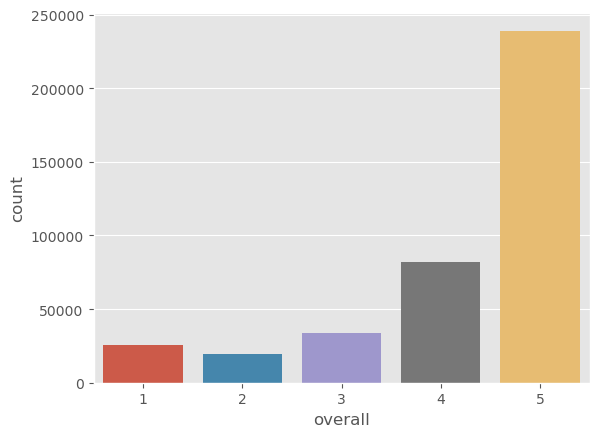

In [8]:
sns.countplot(x=df["overall"]);

## Handling Missing Values

In [9]:
df.dropna(subset=["reviewText", "summary"], inplace=True)
df.shape

(399763, 10)

In [10]:
df.isnull().sum()

Unnamed: 0           0
reviewerID           0
asin                 0
reviewerName      5949
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

## FEATURE ENGINEERING

In [11]:
# The unixReviewTime is converted from Unix time to the more intuitive datetime datatype.

df["datetime"] = pd.to_datetime(df["unixReviewTime"], unit="s")

df["year"] = df["datetime"].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day


In [12]:
# unnecessary columns dropped
df.drop(["Unnamed: 0", "unixReviewTime", "reviewTime", "reviewerID","asin","datetime","reviewerName"], axis=1, inplace=True)

In [13]:
df.sample(3)

,helpful,reviewText,overall,summary,year,month,day
79553,"[0, 0]",The Canon Powershot A80 has been used by my fa...,5,Great Pictures from a General-Purpose Camera,2011,4,16
304299,"[0, 0]",it was very easy to open the asus eee pc 1000 ...,4,worked as expected,2009,3,25
364114,"[0, 0]",I am a new gramma and love this camera. It is ...,5,Love this camera,2009,3,11


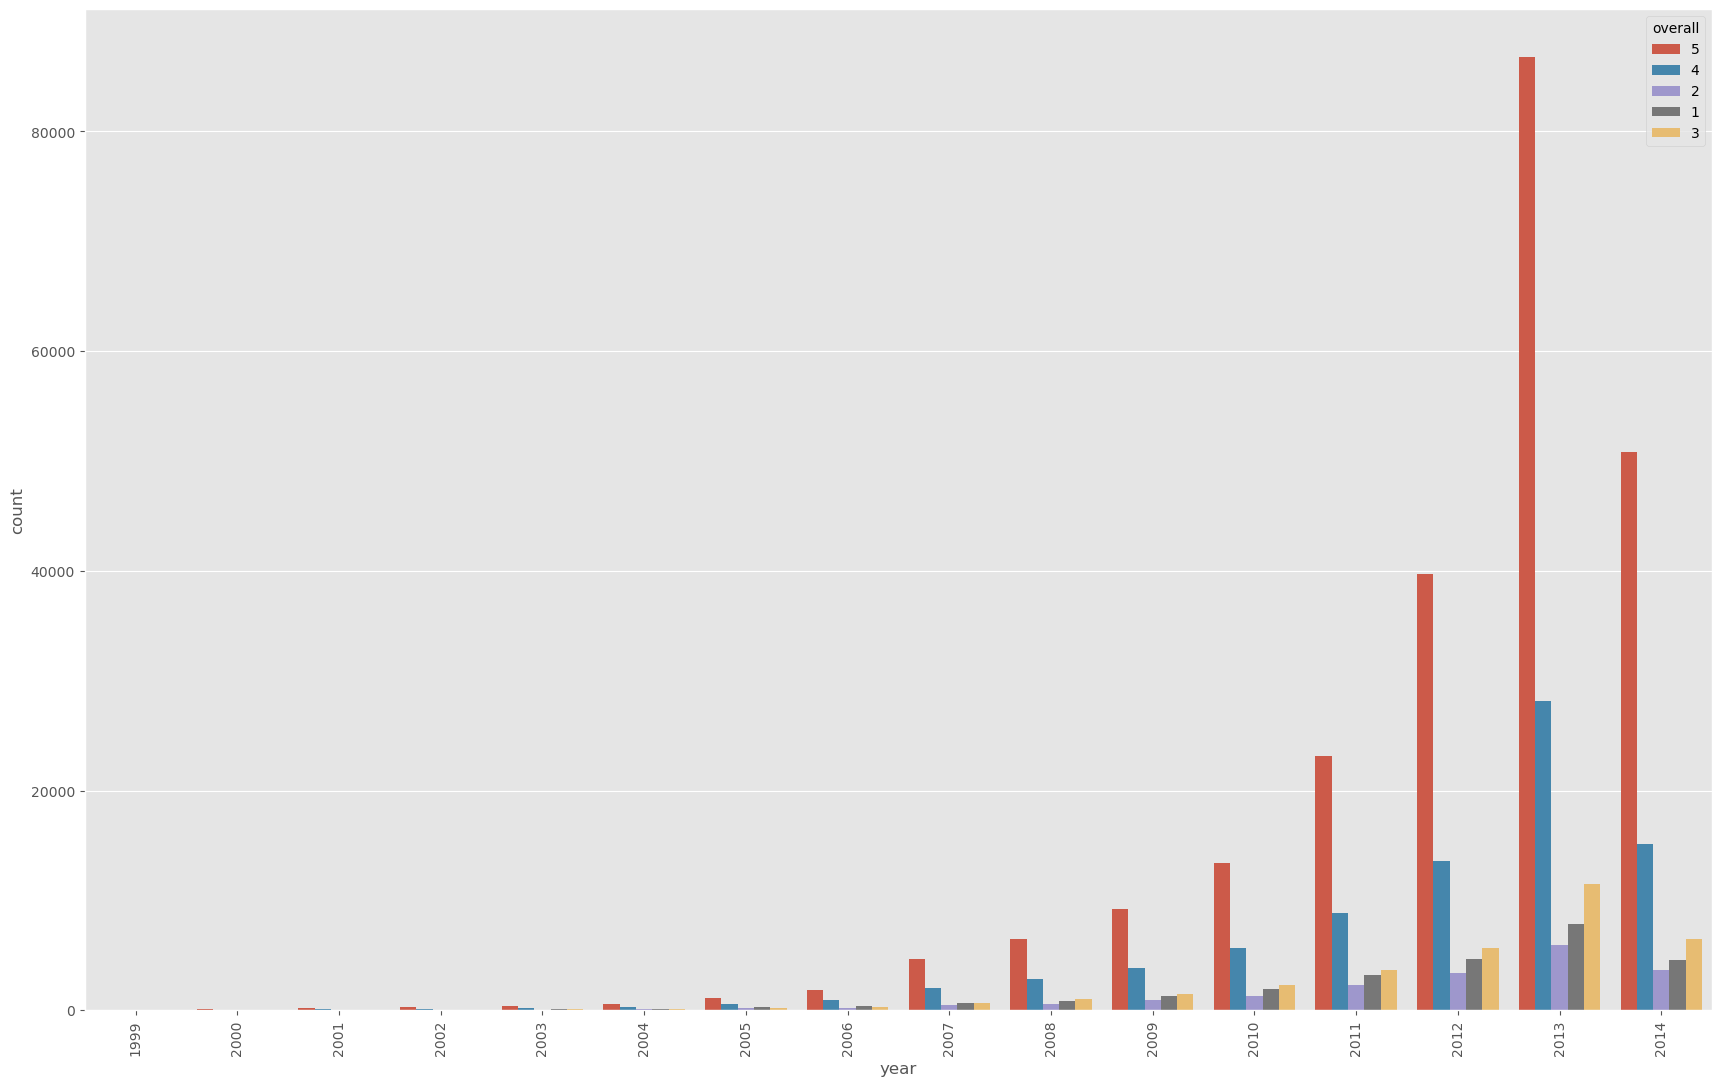

In [14]:
df["overall"] = df["overall"].astype(str)

plt.figure(figsize=(21, 13))
plt.xticks(rotation=90)
sns.countplot(x=df["year"], hue=df["overall"]);

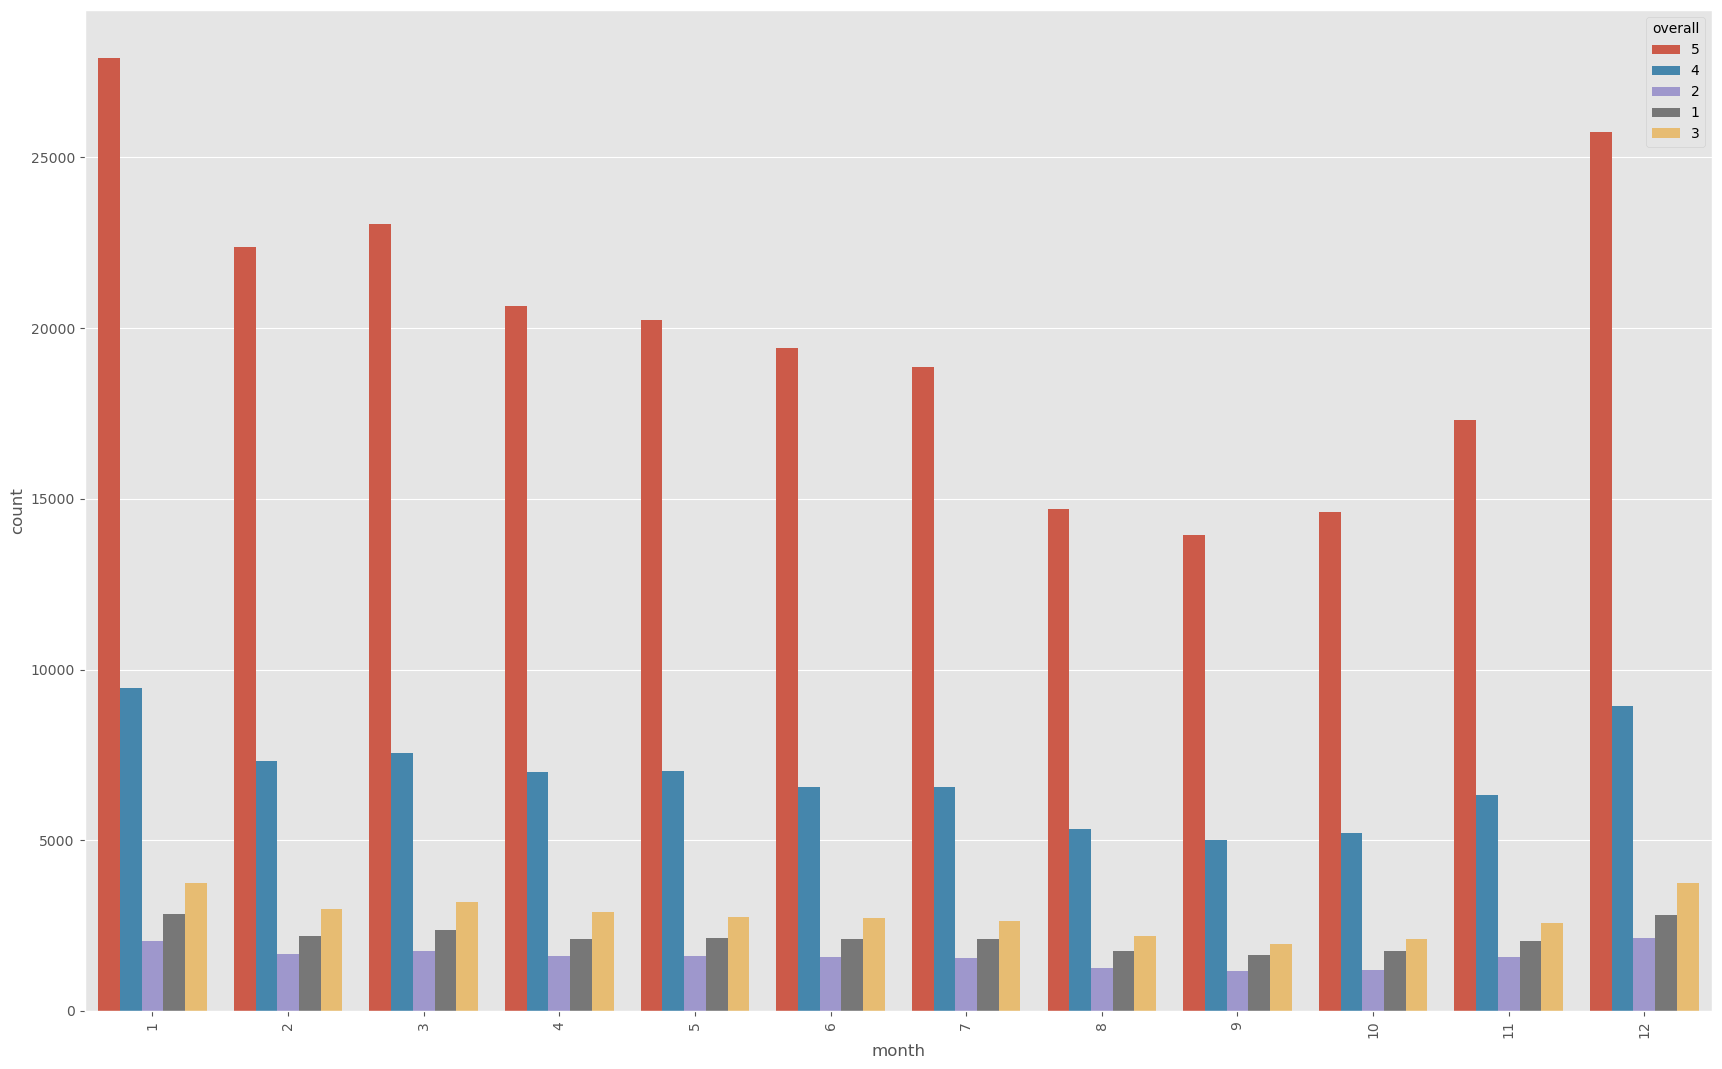

In [15]:


plt.figure(figsize=(21, 13))
plt.xticks(rotation=90)
sns.countplot(x=df["month"], hue=df["overall"]);

Most negative comments were made in January and December

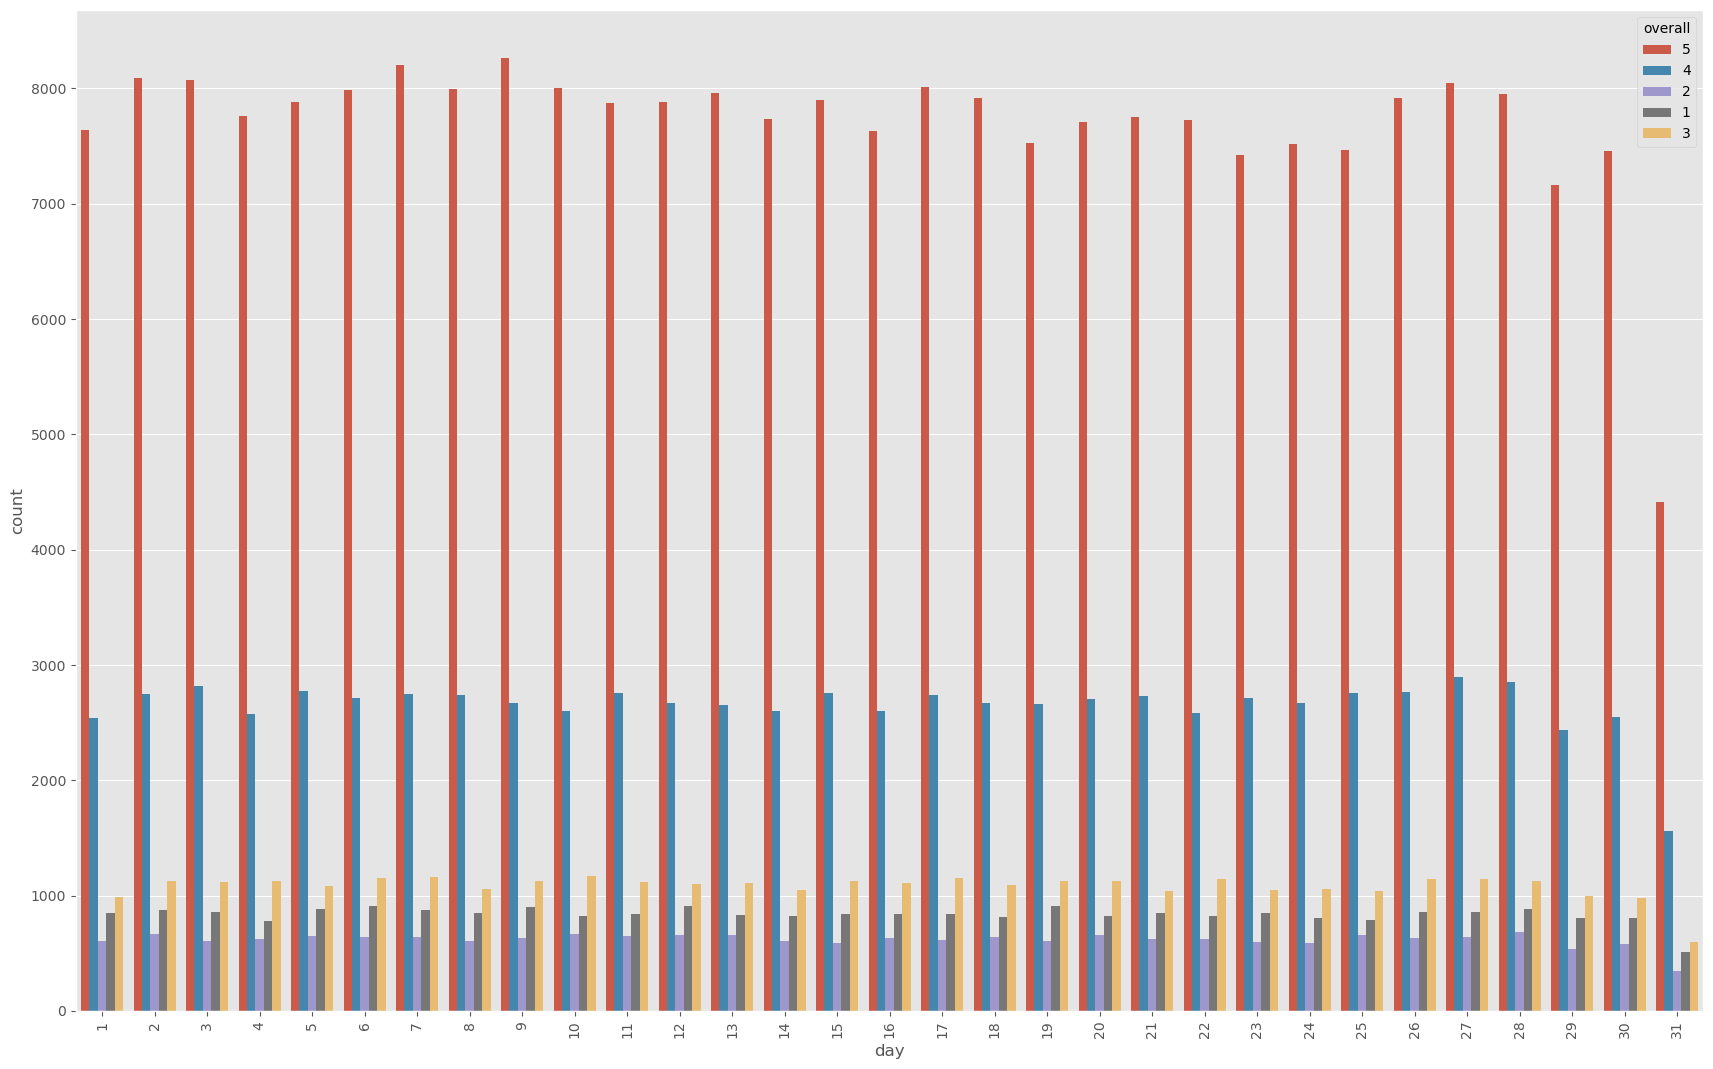

In [16]:
plt.figure(figsize=(21, 13))
plt.xticks(rotation=90)
sns.countplot(x=df["day"], hue=df["overall"]);

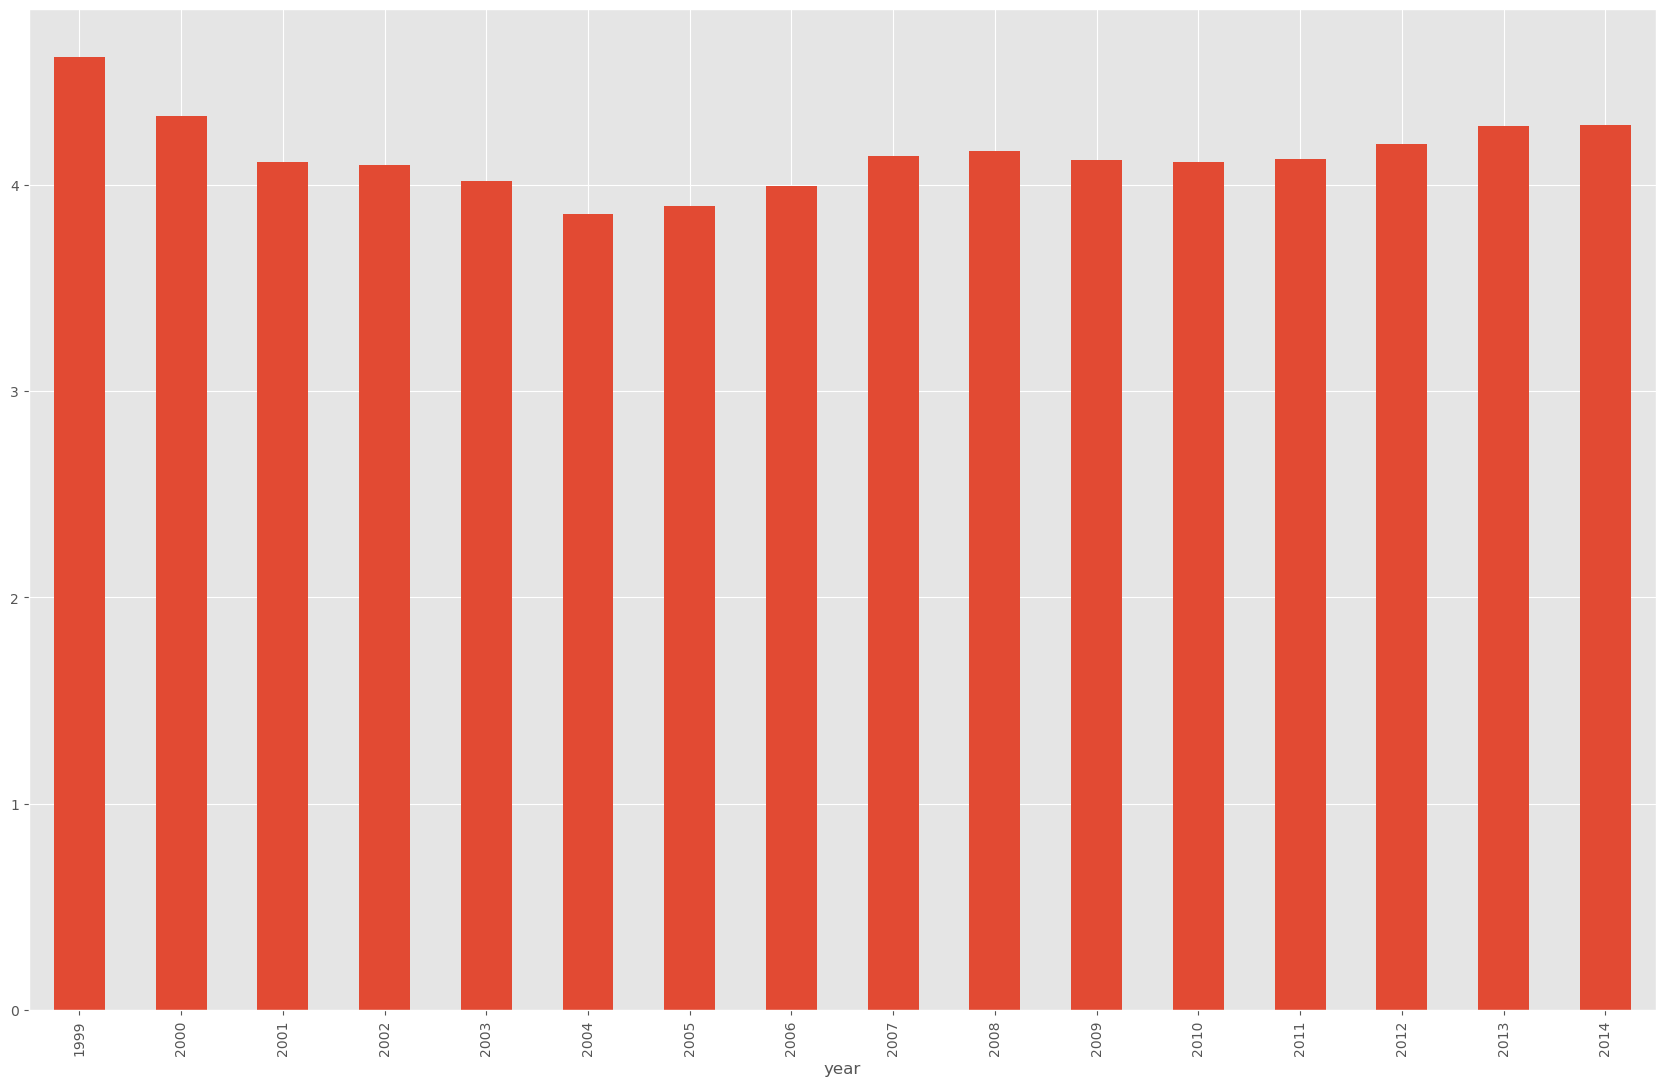

In [17]:
df['overall'] = pd.to_numeric(df['overall'], errors='coerce')

plt.xticks(rotation=90)
df.groupby("year")["overall"].mean().plot.bar(figsize=(21, 13));



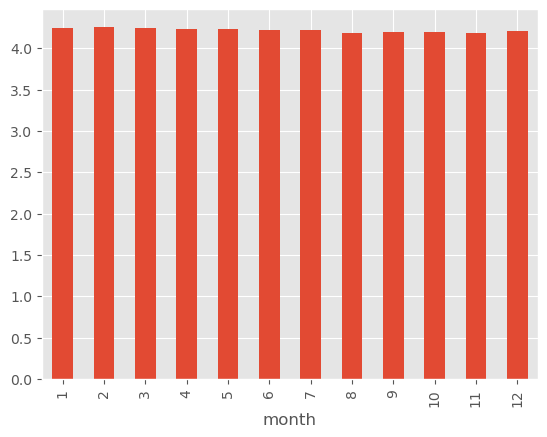

In [18]:
df.groupby("month")["overall"].mean().plot.bar();

In [19]:
df = df.reset_index(drop=True)


In [20]:
df.head()

,helpful,reviewText,overall,summary,year,month,day
0,"[0, 0]",Bought these for my son's Christmas for him to...,5,Great sound from such a small package,2013,12,30
1,"[0, 0]",I found this item on Amazon and I continue to ...,5,Great Value,2009,10,22
2,"[1, 1]","Good price, good product, works fine. I wish ...",5,Works Fine,2012,2,10
3,"[0, 1]","I have this frame in the 7 and 10"" sizes, and ...",5,Love it,2011,5,4
4,"[0, 0]","This is the most basic, simplest way to get 2 ...",5,Pefect,2013,4,17


## Sentiment Analysis

In [21]:
df["sentiment"] = df.overall.map({1:"negative", 2:"negative", 3:"neutral", 4:"positive", 5:"positive"})
df.sample(3)

,helpful,reviewText,overall,summary,year,month,day,sentiment
42104,"[0, 0]",Used these when we were snorkeling in Hawaii. ...,5,Kept Water Out,2014,5,9,positive
172611,"[16, 20]",At this point there is no reason to buy the X-...,5,"Huge upgrade from any other Fuji, including XPRO.",2013,11,24,positive
105866,"[0, 0]",But very poor images (or white out) when the s...,3,High quality images when the sun is behind the...,2013,10,31,neutral


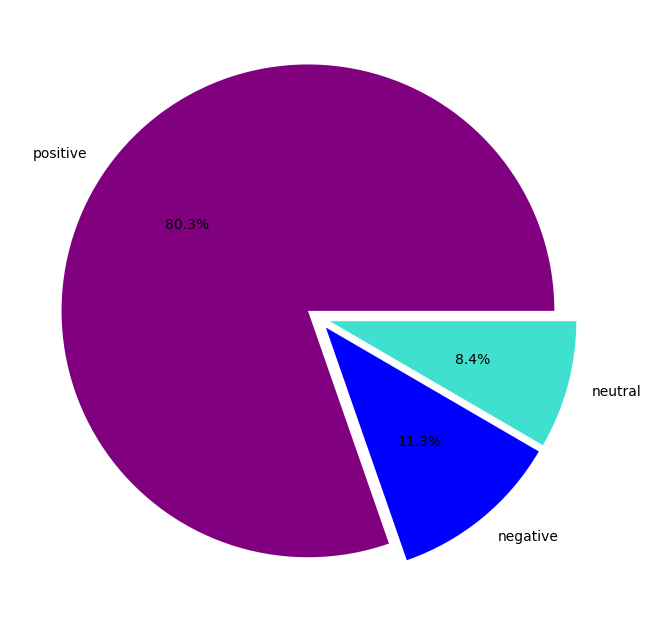

In [22]:
x = df["sentiment"].value_counts(normalize=True)
my_color = ["purple","blue", "turquoise"]
my_explode = [0.05,0.05,0.05]
label = ["positive","negative","neutral"]
plt.figure(figsize=(8, 8))

plt.pie(x, colors=my_color, labels=label, explode=my_explode, autopct="%1.1f%%");


## Text Preprocessing

In [23]:
df["reviewText"][1], df["reviewText"][3], df["reviewText"][4], df["reviewText"][5]

('I found this item on Amazon and I continue to look for a better price but have not found a better price yet.  I was concerned about some of the complaints about reliability but so far the card has been reliable and I feel like I got a great deal. I installed it in my new Kodak Zi8 over a month ago and I have not removed any media files yet but there is still pleanty of room left I am really happy with this purchase.',
 'I have this frame in the 7 and 10" sizes, and the flexibility is great, as is the online play list creation - It\'s so easy to get pictures on here because they give you so many options.  All of my frames needed to upgrade firmware as soon as I connected them to my network to function properly, but this was quick and painless, and I found it has plenty of room for my pictures, and the image quality is the best I\'ve seen in an electronic picture frame.  I love being able to email pictures to the frame I gave my wife (she keeps it on her desk at work).  The only downsi

In [24]:
# converting all text to lower case
df["reviewText"] = df["reviewText"].str.lower()
# removing punctuation
df["reviewText"] = df["reviewText"].str.replace("[^\w\s]", " ", regex=True)
# removing extra spaces
df["reviewText"] = df["reviewText"].str.replace("\n", " ", regex=True).replace("\r", " ", regex=True).replace("\t", " ", regex=True).str.strip()
# removing digits
df["reviewText"] = df["reviewText"].str.replace("\d+", " ", regex=True)
# removing html entities
df["reviewText"] = df["reviewText"].str.replace("\&\#[0-9]+\;", " ", regex=True)


In [25]:
df["reviewText"][1], df["reviewText"][3], df["reviewText"][4], df["reviewText"][5]

('i found this item on amazon and i continue to look for a better price but have not found a better price yet   i was concerned about some of the complaints about reliability but so far the card has been reliable and i feel like i got a great deal  i installed it in my new kodak zi  over a month ago and i have not removed any media files yet but there is still pleanty of room left i am really happy with this purchase',
 'i have this frame in the   and    sizes  and the flexibility is great  as is the online play list creation   it s so easy to get pictures on here because they give you so many options   all of my frames needed to upgrade firmware as soon as i connected them to my network to function properly  but this was quick and painless  and i found it has plenty of room for my pictures  and the image quality is the best i ve seen in an electronic picture frame   i love being able to email pictures to the frame i gave my wife  she keeps it on her desk at work    the only downside i

In [26]:
df.to_csv("df_cleaned.csv")

In [27]:
df = pd.read_csv("df_cleaned.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.head(1)

,helpful,reviewText,overall,summary,year,month,day,sentiment
0,"[0, 0]",bought these for my son s christmas for him to...,5,Great sound from such a small package,2013,12,30,positive


## Word Cloud

In [28]:
def wc(data, bgcolor):
    plt.figure(figsize=(10,10))
    mask = np.array(Image.open("technology.png"))
    wc = WordCloud(background_color=bgcolor, stopwords=STOPWORDS, mask = mask)

    data_str = data.fillna('').astype(str)

    wc.generate("".join(data_str))
    plt.imshow(wc)
    plt.axis("off")


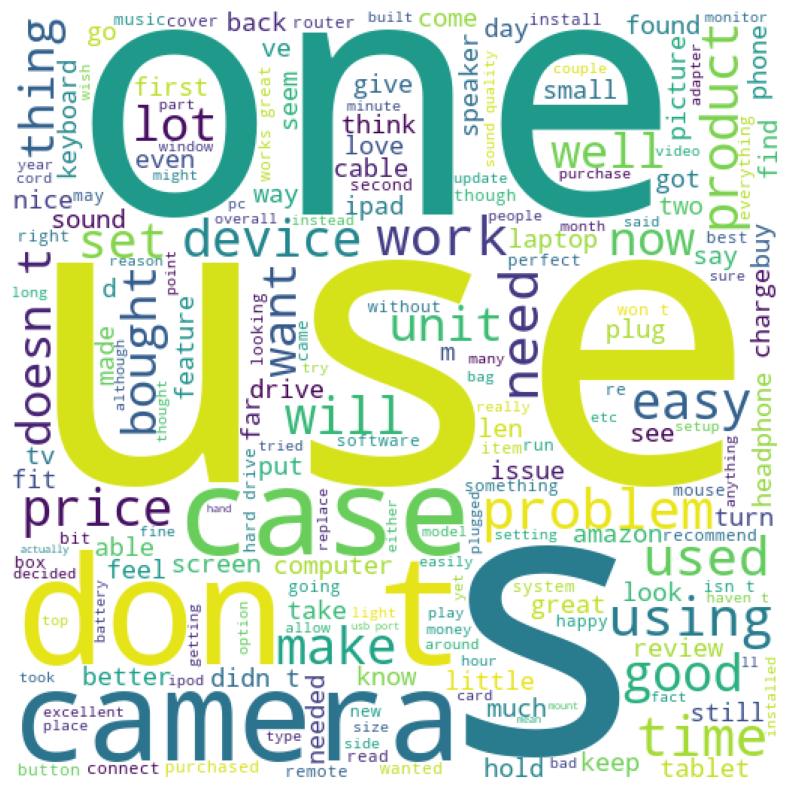

In [29]:
# all reviews
wc(df["reviewText"], "white")

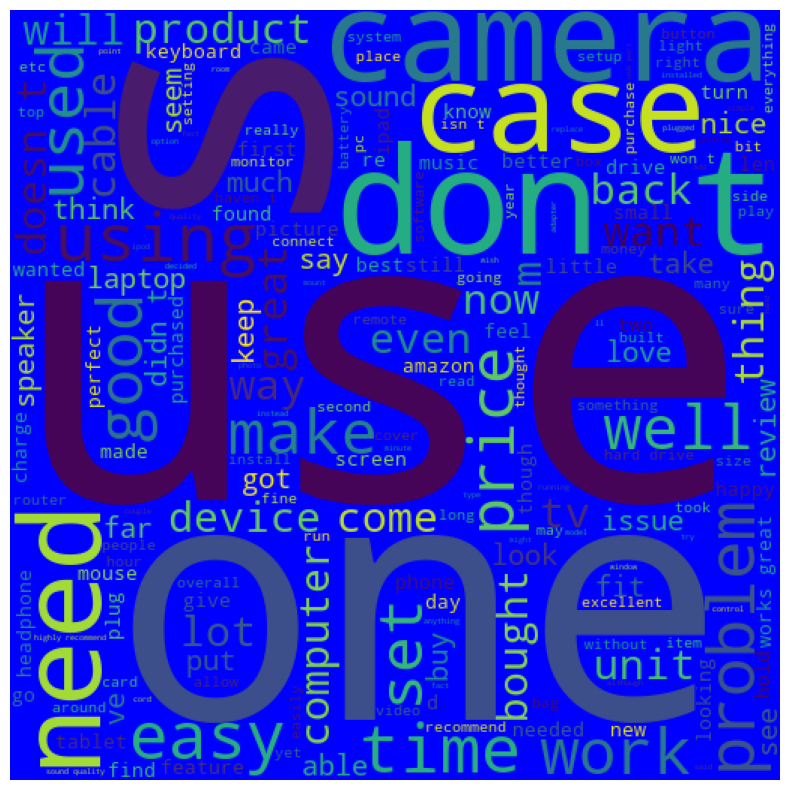

In [30]:
# positive reviews
wc(df[df["sentiment"]=="positive"]["reviewText"], "blue")

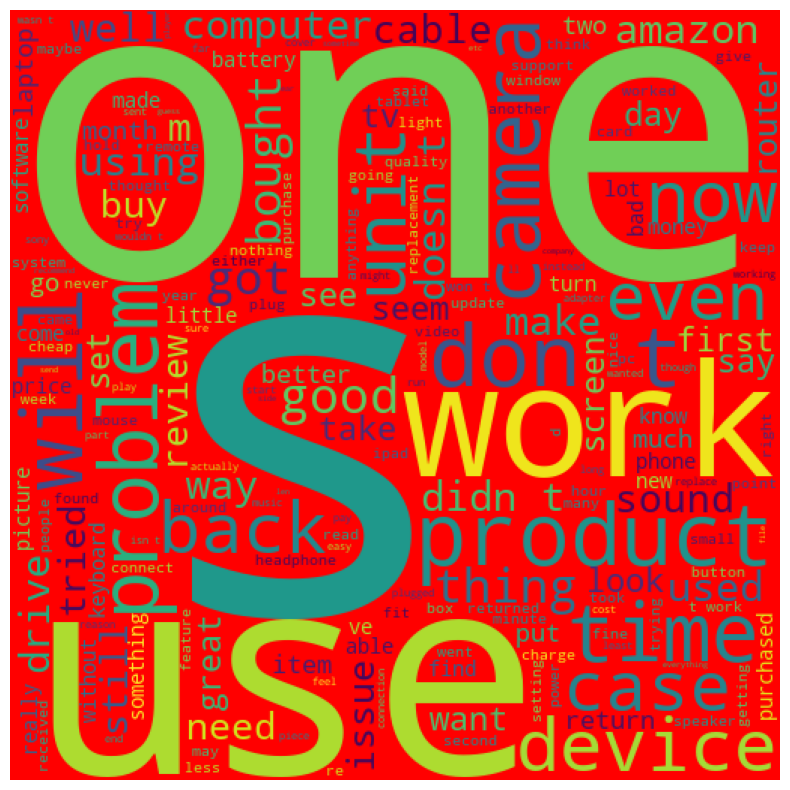

In [31]:
# negative reviews
wc(df[df["sentiment"]=="negative"]["reviewText"], "red")

In [37]:
df['reviewText'] = df['reviewText'].str.strip()
df = df[df['reviewText'] != '']

In [33]:
df["language"] = df["reviewText"].apply(detect)

In [34]:
df["language"].value_counts()

language
en    398719
es       471
af       164
ro        65
ca        54
da        30
pt        30
so        28
cy        22
sl        21
it        20
fr        19
no        16
et        16
nl        14
pl        11
tl         9
id         8
sk         7
sv         7
hr         7
cs         6
sq         6
sw         5
tr         3
lv         2
fi         2
Name: count, dtype: int64

In [38]:
# other languages won't affect our model(has little quantity) so we took only english 
df = df[df["language"] == "en"]

In [39]:
df["language"].value_counts()

language
en    398719
Name: count, dtype: int64

In [40]:
df.sample(5)

,helpful,reviewText,overall,summary,year,month,day,sentiment,language
328610,"[0, 0]",i ve got to say that while i bought this for m...,5,Indispensable,2013,5,13,positive,en
33017,"[1, 2]",i was pleasantly surprised at this unit it is...,4,"Pleasantly surprised, but not perfect",2011,6,11,positive,en
88253,"[0, 0]",i was looking for a portable dvd player with a...,1,So Hopeful but Disappointed In the End,2011,12,31,negative,en
312331,"[0, 0]",i am using this for my office deck put on ...,5,great arms for led monitor,2014,2,5,positive,en
366119,"[1, 1]",works as advertized its the only solution b...,5,"Mounts to Sony Bravia TV, Works great",2013,2,4,positive,en


## Modelling

In [60]:
X = df["reviewText"]
df["sentiment_encoded"] = df["sentiment"].map({"positive": 2, "negative": 0, "neutral": 1})
y = df["sentiment_encoded"]

In [61]:
def lemmafn(X):
    words = TextBlob(X).words
    return [pr.stem(word) for word in words]

In [62]:
vect = CountVectorizer(stop_words="english", analyzer=lemmafn, ngram_range=(1, 4), min_df=4)
X = vect.fit_transform(X)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Deep Learning

In [82]:
model = Sequential()
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(16, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [83]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

In [84]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=30, 
                    validation_split=0.2, 
                    callbacks=[early_stopping, checkpoint, reduce_lr], 
                    batch_size=128)

model.load_weights("best_model.keras")

Epoch 1/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 74s 35ms/step - accuracy: 0.7066 - loss: 0.8765 - val_accuracy: 0.8487 - val_loss: 0.4184 - learning_rate: 0.0010
Epoch 2/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 69s 34ms/step - accuracy: 0.8398 - loss: 0.4479 - val_accuracy: 0.8529 - val_loss: 0.4019 - learning_rate: 0.0010
Epoch 3/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - accuracy: 0.8498 - loss: 0.4130 - val_accuracy: 0.8551 - val_loss: 0.3975 - learning_rate: 0.0010
Epoch 4/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.8561 - loss: 0.3924 - val_accuracy: 0.8573 - val_loss: 0.3933 - learning_rate: 0.0010
Epoch 5/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - accuracy: 0.8595 - loss: 0.3773 - val_accuracy: 0.8572 - val_loss: 0.3945 - learning_rate: 0.0010
Epoch 6/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - accuracy: 0.8630 - loss: 0.3659 - val_accuracy: 0.8572 - val_loss: 0.3944 - learning_rate: 0.0010
Epoch 7/30
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - accura

In [85]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

2492/2492 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8597 - loss: 0.3865
Loss: 0.38986679911613464
Accuracy: 0.8581585884094238


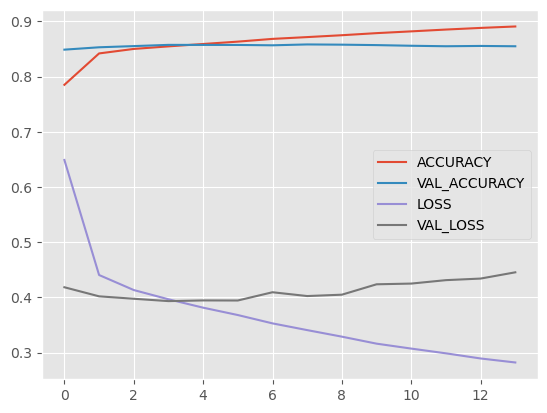

In [86]:
plt.plot(history.history["accuracy"], label="ACCURACY")
plt.plot(history.history["val_accuracy"], label="VAL_ACCURACY")
plt.plot(history.history["loss"], label="LOSS")
plt.plot(history.history["val_loss"], label="VAL_LOSS")
plt.legend();


In [87]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis=1)
print(classification_report(y_test, prediction))


2492/2492 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

           0       0.68      0.63      0.65      8983
           1       0.00      0.00      0.00      6728
           2       0.88      0.98      0.93     64033

    accuracy                           0.86     79744
   macro avg       0.52      0.54      0.53     79744
weighted avg       0.78      0.86      0.82     79744



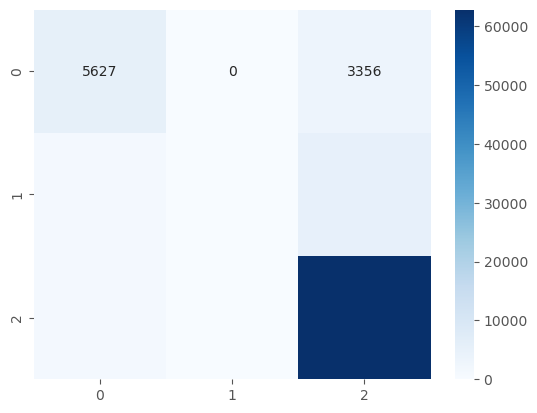

In [88]:
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt="d", cmap="Blues");

In [89]:
pred = pd.DataFrame({"y_test": y_test, "prediction": prediction})
pred["label"] = pred["prediction"].map({0: "negative", 1: "neutral", 2: "positive"})
pred.sample(30)

,y_test,prediction,label
157516,2,2,positive
370100,2,2,positive
344886,1,2,positive
142083,2,2,positive
399386,2,2,positive
375400,1,0,negative
192624,2,2,positive
18394,1,2,positive
147035,2,2,positive
373656,2,2,positive


## Top complaint words

In [102]:
df_cleaned = pd.read_csv("df_cleaned.csv")
df_cleaned.drop("Unnamed: 0", axis=1, inplace=True)


In [106]:
df_cleaned[["polarity","subjectivity"]]=df_cleaned["reviewText"].apply(lambda Text:pd.Series(TextBlob(Text).sentiment))

In [108]:
neg_pol = df_cleaned[df_cleaned["polarity"] < -0.3]["reviewText"]

stop_words = stopwords.words('english')

vect = CountVectorizer(stop_words=stop_words, ngram_range=(2,3))
X = vect.fit_transform(neg_pol)

# calculate the frequency
word_totals = X.sum(axis=0)
words_freq = [(word, word_totals[0, idx]) for word, idx in vect.vocabulary_.items()]
words_df = pd.DataFrame(words_freq, columns=['word', 'frequency'])

top_words = words_df.sort_values(by='frequency', ascending=False).head(23)

print(top_words)

                   word  frequency
2441         works well         61
1556           go wrong         47
1510        waste money         43
3742    would recommend         38
1865   customer service         36
28346         weak weak         31
28349    weak weak weak         30
6630          work well         30
1128          never buy         29
565         buy another         27
5015          stay away         27
427          piece crap         26
2601         every time         25
3582         hard drive         24
1098    stopped working         21
4071          would buy         21
6211          could get         21
3976       poor quality         20
1725         save money         19
2014            sd card         19
566         another one         19
1440            get pay         18
2368   screen protector         18


In [109]:
neg_pol = df_cleaned[df_cleaned["polarity"] < -0.3]["reviewText"]

stop_words = stopwords.words('english')

vect = CountVectorizer(stop_words=stop_words, ngram_range=(3,5))
X = vect.fit_transform(neg_pol)

# calculate the frequency
word_totals = X.sum(axis=0)
words_freq = [(word, word_totals[0, idx]) for word, idx in vect.vocabulary_.items()]
words_df = pd.DataFrame(words_freq, columns=['word', 'frequency'])

top_words = words_df.sort_values(by='frequency', ascending=False).head(23)

print(top_words)

                           word  frequency
40736            weak weak weak         30
40739       weak weak weak weak         29
40742  weak weak weak weak weak         28
8559          never buy another         13
18086          waste time money          8
42083             kb qd mb iops          8
42036                qd mb iops          8
42035                  kb qd mb          8
18005             cant go wrong          7
3486          buy another brand          7
62157          works like charm          6
7023          stay away product          6
42084         qd mb iops random          6
22884    would recommend anyone          6
43049            blu ray player          6
42037            mb iops random          6
42134      kb qd mb iops random          6
13274             give one star          5
26516   would recommend product          5
69                 mac book pro          5
42027           mb srandom read          5
8766             could get work          5
778        

## Top positive words

In [111]:
pos_pol = df_cleaned[df_cleaned["polarity"] > 0.7]["reviewText"]

stop_words = stopwords.words('english')

vect = CountVectorizer(stop_words=stop_words, ngram_range=(3,5))
X = vect.fit_transform(pos_pol)

# calculate the frequency
word_totals = X.sum(axis=0)
words_freq = [(word, word_totals[0, idx]) for word, idx in vect.vocabulary_.items()]
words_df = pd.DataFrame(words_freq, columns=['word', 'frequency'])

top_words = words_df.sort_values(by='frequency', ascending=False).head(23)

print(top_words)

                            word  frequency
1815      would recommend anyone         87
12787        great product great         58
12788        product great price         56
12796  great product great price         46
17778    would recommend product         39
1809           great price great         35
13104       works great problems         34
396               kindle fire hd         31
2690           cable works great         30
21919        product works great         30
4865            works like charm         27
9209    recommend anyone looking         27
10910          works great great         27
20471      great would recommend         26
4845          works great issues         24
6045          samsung galaxy tab         23
234          great product price         22
8251         quality great price         21
14335             blu ray player         21
4323            card works great         21
29611          works great would         20
4844              tv works great

In [112]:
pos_pol = df_cleaned[df_cleaned["polarity"] > 0.7]["reviewText"]

stop_words = stopwords.words('english')

vect = CountVectorizer(stop_words=stop_words, ngram_range=(2,3))
X = vect.fit_transform(pos_pol)

# calculate the frequency
word_totals = X.sum(axis=0)
words_freq = [(word, word_totals[0, idx]) for word, idx in vect.vocabulary_.items()]
words_df = pd.DataFrame(words_freq, columns=['word', 'frequency'])

top_words = words_df.sort_values(by='frequency', ascending=False).head(23)

print(top_words)

                  word  frequency
68         works great       1295
1332       great price        506
182      great product        365
164    works perfectly        361
29     would recommend        337
41          work great        204
697         good price        199
1957      good quality        197
1273      worked great        191
52      fits perfectly        183
1801        works well        161
1804         would buy        152
852      works perfect        133
1337  recommend anyone        127
763   worked perfectly        125
1180    happy purchase        125
2817         great buy        119
748        price great        115
5025     great quality        113
208          well made        110
1462       looks great        107
854        great value        106
970       good product        104


## Named-Entity Recognition ###
We've seen *gensim* perform word tagging to identify part-of-speech. Now we use *spaCy* to go further and identify what nouns in the documents refer to. Some Named-Entity Recognition (*NER*) classification tags include distinguishing persons, organizations, products, places, dates, etc.

In exploring *spaCy*, we'll be using the `most_helpful_text`, which is the highest-rated product review by Amazon users. The `helpful` series from the `df` dataframe is actually a list with its first element storing the number of *helpful* votes a review received, and the second element containing the total number of *helpful* and *not helpful* review votes.

In [122]:
helpful = df["helpful"].tolist()
most_helpful = max(helpful, key=lambda x: x[0])

most_helpful_idx = df["helpful"].astype(str) == str(most_helpful)
most_helpful_idx = df[most_helpful_idx].index

most_helpful_text = df["reviewText"].iloc[most_helpful_idx].values[0]

print(most_helpful_text)

We got this GPS for my husband who is an (OTR) over the road trucker.  Very Impressed with the shipping time, it arrived a few days earlier than expected...  within a week of use however it started freezing up... could of just been a glitch in that unit.  Worked great when it worked!  Will work great for the normal person as well but does have the "trucker" option. (the big truck routes - tells you when a scale is coming up ect...)  Love the bigger screen, the ease of use, the ease of putting addresses into memory.  Nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that's just my luck.  I contacted the seller and within minutes of my email I received a email back with instructions for an exchange! VERY impressed all the way around!
